#  Portfolio introduction

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## 2 Assets Portfolio
### Download Stock Quotes from Yahoo! Finance

In [2]:
# Set stocks symbols and time frame
stocks_list = 'AAPL K'  # tickers seperated by space
start_date = '2009-01-01'
end_date = '2019-01-01'

In [3]:
# Read
data = yf.download(tickers=stocks_list, start=start_date,
                   end=end_date, interval="1mo")['Adj Close'].dropna()
print("Stocks Prices:")
print(data.head())

[*********************100%***********************]  2 of 2 completed
Stocks Prices:
                AAPL          K
Date                           
2009-01-01  2.735905  27.345650
2009-02-01  2.711014  24.360100
2009-03-01  3.190928  23.129932
2009-04-01  3.819583  26.590273
2009-05-01  4.122524  27.310135


### Stocks Statistics 

In [4]:
# Calculate monthly returns
monthly_ret = np.log(data).diff().dropna()
print("Stocks Monthly Returns:")
print(monthly_ret.head())

Stocks Monthly Returns:
                AAPL         K
Date                          
2009-02-01 -0.009140 -0.115611
2009-03-01  0.162989 -0.051819
2009-04-01  0.179829  0.139418
2009-05-01  0.076324  0.026712
2009-06-01  0.047594  0.081855


In [5]:
# Mean Returns
mean_ret = monthly_ret.mean()
print("Stocks Mean Returns:")
print(mean_ret)

Stocks Mean Returns:
AAPL    0.022099
K       0.004810
dtype: float64


In [6]:
# Sigma
sigma = monthly_ret.std()
print("Stocks Sigma:")
print(sigma)

Stocks Sigma:
AAPL    0.074039
K       0.045390
dtype: float64


In [7]:
# Variance Covariance Matrix
cov_mat = monthly_ret.cov()
print("Variance-Covariance Matrix:")
print(cov_mat)

Variance-Covariance Matrix:
          AAPL         K
AAPL  0.005482  0.000828
K     0.000828  0.002060


In [8]:
# Correlation Matrix
corr_mat = monthly_ret.corr()
print("Correlation Matrix")
print(corr_mat)

Correlation Matrix
          AAPL         K
AAPL  1.000000  0.246316
K     0.246316  1.000000


### Linear Regression

In [9]:
x = np.array(monthly_ret['AAPL']).reshape(-1, 1)
y = np.array(monthly_ret['K'])
model = LinearRegression().fit(x, y)

In [10]:
# coefficient of determination (R-Squared)
print(pd.Series([model.score(x, y)],index=["R-suared"]))

R-suared    0.060672
dtype: float64


In [11]:
# Alpha
print(pd.Series([model.intercept_],index=["Alpha"]))

Alpha    0.001473
dtype: float64


In [12]:
# Beta (slope)
print(pd.Series([model.coef_[0]],index=["Beta"]))

Beta    0.151007
dtype: float64


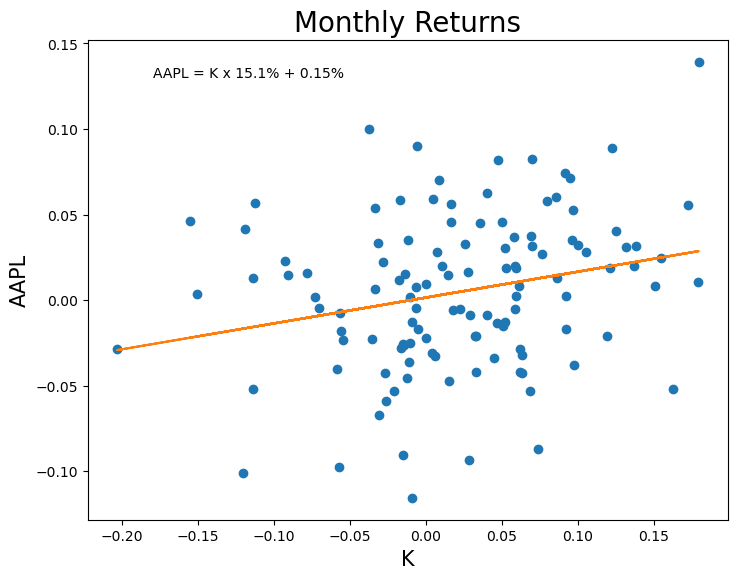

In [13]:
#Scatter Plot
fig = plt.figure() # create a canvas
ax = fig.add_axes([0., 0., 1., 1.]) # add axes
ax.plot(x, y, 'o') # scatter plot
ax.plot(x, model.intercept_ + x * model.coef_) # linear regression line

# Titles and axes names
ax.set_title(r'Monthly Returns', fontsize = 20)
ax.set_xlabel(r'K', fontsize = 15)
ax.set_ylabel(r'AAPL', fontsize = 15)

# Equation
alpha = str(round(model.intercept_ * 100, 2)) + "%"
beta = str(round(model.coef_[0] * 100, 2)) + "%"
equation = "AAPL = K x " + beta +" + "+ alpha
ax.text(y = 0.13, x = -0.18,s = equation)

# Show plot
plt.show()

### Building a portfolio

In [14]:
# Set proportions
Xa = 0.5
Xb = 1 - Xa
proportions = pd.DataFrame(data = [[Xa], [Xb]],columns = ['Weights'], index = ['AAPL','K']).transpose()
print(proportions)

         AAPL    K
Weights   0.5  0.5


In [15]:
# Portfolio Returns
t_monthly_ret = monthly_ret.transpose()
port_ret = proportions.dot(t_monthly_ret).transpose()
port_ret.columns = ['Portfolio Returns']
print(port_ret.head())

            Portfolio Returns
Date                         
2009-02-01          -0.062375
2009-03-01           0.055585
2009-04-01           0.159624
2009-05-01           0.051518
2009-06-01           0.064725


In [16]:
# Calculate portfolio Variance
port_var = proportions.dot(cov_mat).dot(proportions.transpose()).iloc[0,0]
print(pd.Series(port_var,index=["Portfolio Variance"]))

Portfolio Variance    0.002299
dtype: float64


In [17]:
# Calculate portfolio Sigma
port_sigma = math.sqrt(port_var)
print(pd.Series(port_sigma,index=["Portfolio Sigma"]))

Portfolio Sigma    0.047952
dtype: float64


### Calculating the  Minimum-Variance Portfolio

In [18]:
# Analytical Approach 
AAPL_var = cov_mat.loc["AAPL"]["AAPL"]
K_var = cov_mat.loc["K"]["K"]
AAPL_K_cov = cov_mat.loc["AAPL"]["K"]

# AAPL weight:
GMVP_AAPL = (K_var - AAPL_K_cov) / (AAPL_var + K_var - 2 * AAPL_K_cov)

# K weight
GMVP_K = 1 - GMVP_AAPL

# Weights
proportions = pd.Series({'AAPL': GMVP_AAPL, 'K': GMVP_K})
print(proportions)

AAPL    0.20938
K       0.79062
dtype: float64


In [19]:
# Calculating GMVP variance:
proportions = pd.DataFrame(data = [GMVP_AAPL, GMVP_K],columns = ['Weights'], index = ['AAPL','K']).transpose()
GMVP_var = proportions.dot(cov_mat).dot(proportions.transpose()).iloc[0,0]
print(pd.Series(GMVP_var,index=["GMVP Variance"]))

GMVP Variance    0.001802
dtype: float64


In [20]:
# Calculate portfolio Sigma
GMVP_sigma = math.sqrt(GMVP_var)
print(pd.Series(GMVP_sigma,index=["GMVP Sigma"]))

GMVP Sigma    0.042453
dtype: float64


In [21]:
# Solver Approach
# Define function for portfolio variance
def port_var(Xa):
    Xb = 1- Xa
    proportions = np.array([Xa, Xb]).transpose()
    port_var = np.dot(proportions, cov_mat).dot(proportions.transpose())
    return port_var

In [22]:
# Minimize Portfolio Variance
x0 = 0 # initial guess for AAPL's weight
result = minimize(port_var, x0, method='nelder-mead')
print(pd.Series(result.x,index=["Apple's Weight"])) # AAPL's weight result

Apple's Weight    0.209375
dtype: float64


### Case of N assets ( 4 assetst example)

In [32]:
# Input: Variance Covariance Matrix
var_cov_mat = np.array([[0.10,0.01,0.03,0.05],
                           [0.01,0.30,0.06,-0.04],
                           [0.03,0.06,0.40,0.02],
                           [0.05,-0.04,0.02,0.50]])

# Input: mean returns
mean_returns = np.array([0.06, 0.08, 0.1, 0.15]).transpose()

# Input: Portfolio weights
port_x_wei = np.array([0.2, 0.3, 0.4, 0.1]).transpose()
port_y_wei = np.array([0.2, 0.1, 0.1, 0.6]).transpose()

In [33]:
# Portfolios Mean Returns
port_x_ret = np.dot(mean_returns, port_x_wei)
port_y_ret = np.dot(mean_returns, port_y_wei)

In [34]:
# Result
print("Portfolio's Returns:")
print(pd.Series([port_x_ret,port_y_ret],index=['X','Y']))

Portfolio's Returns:
X    0.091
Y    0.120
dtype: float64


In [35]:
# Portfolios variance calculation of n-assets
port_x_var = np.dot(port_x_wei, var_cov_mat).dot(port_x_wei.transpose())
port_y_var = np.dot(port_y_wei, var_cov_mat).dot(port_y_wei.transpose())

In [36]:
# Result
print("Portfolio's Variance:")
print(pd.Series([port_x_var,port_y_var],index=['X','Y']))

Portfolio's Variance:
X    0.1216
Y    0.2034
dtype: float64


In [37]:
# Portfolios Standard deviation
port_x_sigma = math.sqrt(port_x_var)
port_y_sigma = math.sqrt(port_y_var)

In [38]:
# Result
print("Portfolio's Sigma:")
print(pd.Series([port_x_sigma,port_y_sigma],index=['X','Y']))

Portfolio's Sigma:
X    0.348712
Y    0.450999
dtype: float64


In [39]:
# Covariance(X,Y)
cov_xy = np.dot(port_x_wei, var_cov_mat).dot(port_y_wei.transpose())
print(pd.Series(cov_xy,index=['Covariance(x,y)']))

Covariance(x,y)    0.0714
dtype: float64


In [40]:
# Correlation Coefficient (X,Y)
correl_xy = cov_xy / (port_x_sigma * port_y_sigma)
print(pd.Series(correl_xy,index=['Correlation(x,y)']))

Correlation(x,y)    0.454
dtype: float64


### Envelope Portfolios
 Portfolio Z is a portfolio constructed of portfolio X and portfolio Y. 

In [41]:
# Input:  proportion of X
Xa = 0.3
port_z_weights = np.array([Xa, 1-Xa]).transpose()
print("Proportions of X and Y:")
print(pd.Series(port_z_weights,index=['X','Y']))

Proportions of X and Y:
X    0.3
Y    0.7
dtype: float64


In [42]:
# Portfolio X Returns
port_z_ret = np.dot(port_z_weights, np.array([port_x_ret, port_y_ret]))
print(pd.Series(port_z_ret,index=["Prtfolio Z Return"]))

Prtfolio Z Return    0.1113
dtype: float64


In [43]:
# Portfolio Variance
port_z_var = port_z_weights[0] ** 2 * port_x_var + port_z_weights[1] ** 2 * port_y_var + 2 * np.prod(port_z_weights) * cov_xy
print(pd.Series(port_z_var,index=["Prtfolio Z Variance"]))

Prtfolio Z Variance    0.140598
dtype: float64


In [44]:
# Portfolio Sigma
port_z_sigma = math.sqrt(port_z_var)
print(pd.Series(port_z_sigma,index=["Prtfolio Z Sigma"]))

Prtfolio Z Sigma    0.374964
dtype: float64


#### Plot

In [45]:
# Set an Array of Portfolio Weights
port_x_weight = np.arange(-0.5,1.5,0.1)
port_y_weight = 1-port_x_weight

In [46]:
# Portfolio Z Mean Returns
port_z_ret = port_x_weight * port_x_ret + port_y_weight * port_y_ret
print(pd.Series(port_z_ret))

0     0.1345
1     0.1316
2     0.1287
3     0.1258
4     0.1229
5     0.1200
6     0.1171
7     0.1142
8     0.1113
9     0.1084
10    0.1055
11    0.1026
12    0.0997
13    0.0968
14    0.0939
15    0.0910
16    0.0881
17    0.0852
18    0.0823
19    0.0794
dtype: float64


In [47]:
# Portfolios Sigma
port_z_sigma = (port_x_weight ** 2 * port_x_var + port_y_weight ** 2 * port_y_var + (port_x_weight * port_y_weight) * cov_xy * 2) ** 0.5
print(pd.Series(port_z_sigma))

0     0.617211
1     0.581508
2     0.546807
3     0.513311
4     0.481271
5     0.450999
6     0.422874
7     0.397351
8     0.374964
9     0.356303
10    0.341980
11    0.332554
12    0.328448
13    0.329861
14    0.336722
15    0.348712
16    0.365325
17    0.385964
18    0.410022
19    0.436935
dtype: float64


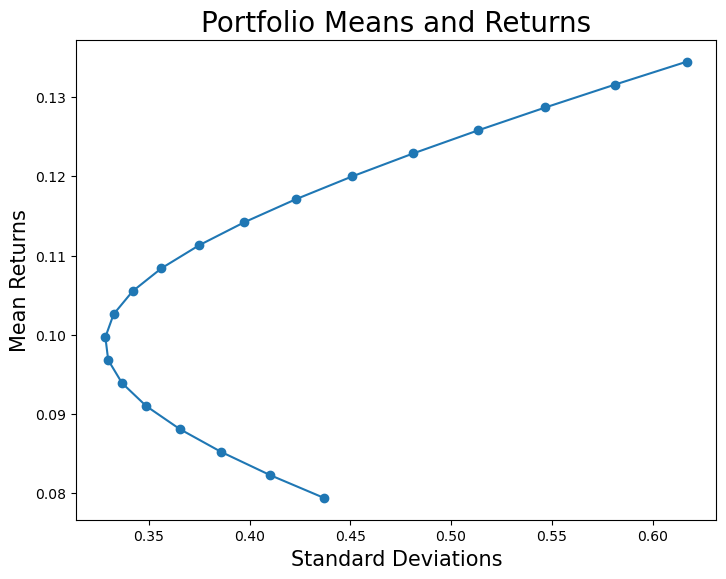

In [48]:
#Scatter Plot
fig = plt.figure() # create a canvas
ax = fig.add_axes([0., 0., 1., 1.]) # add axes
ax.plot(port_z_sigma, port_z_ret, marker='o') # scatter plot

# Titles and axes names
ax.set_title(r'Portfolio Means and Returns', fontsize = 20)
ax.set_xlabel(r'Standard Deviations', fontsize = 15)
ax.set_ylabel(r'Mean Returns', fontsize = 15)

# Show plot
plt.show()